### Business Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. 

This dataset is a bespoke dataset which contains transactions made by credit cards. This dataset contains transactions, where we have 180 frauds out of 4700 transactions. The dataset is highly imbalanced, the positive class (frauds) account for 3.83% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. The input features are transformed to maintain the confidentiality of the original features and more background information about the data. Features PC1, PC2, … PC5 are the principal components obtained with PCA, the only feature which have not been transformed with PCA is 'ID' and 'Class'. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Here is a vary famous dataset on [fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) which is available on Kaggle and similar to this dataset

###  Loading libraries and dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# import dataset

data = pd.read_csv("C:/Users/HP/Downloads/creditcard.csv")

###  Exploring the dataset

In [7]:
# check the shape of dataset
data.shape


(4700, 7)

In [8]:
# check head of the dataset
data.head()


,ID,PC1,PC2,PC3,PC4,PC5,Class
0,0,-55.250726,-13.991887,28.487842,0.158826,-0.926407,0
1,1,-56.875735,-29.555189,1.990487,0.535853,0.452358,0
2,2,-59.144792,-52.266485,9.616903,0.522322,-1.009143,0
3,3,-50.205377,36.441617,14.527072,0.109211,0.593673,0
4,4,-55.707948,-18.275413,16.567411,-0.237213,1.206393,0


In [9]:
# check information about the dataset like - missing values, datatypes etc
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      4700 non-null   int64  
 1   PC1     4700 non-null   float64
 2   PC2     4700 non-null   float64
 3   PC3     4700 non-null   float64
 4   PC4     4700 non-null   float64
 5   PC5     4700 non-null   float64
 6   Class   4700 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 257.2 KB


In [10]:
# check the target class distribution
data['Class'].value_counts()

0    4520
1     180
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

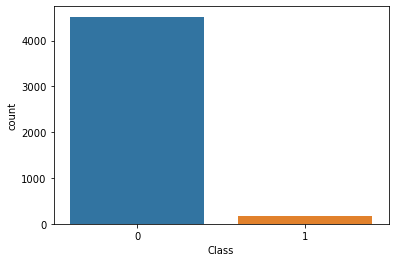

In [11]:
# create a visual plot to see the target distribution
sns.countplot(x='Class',data=data)


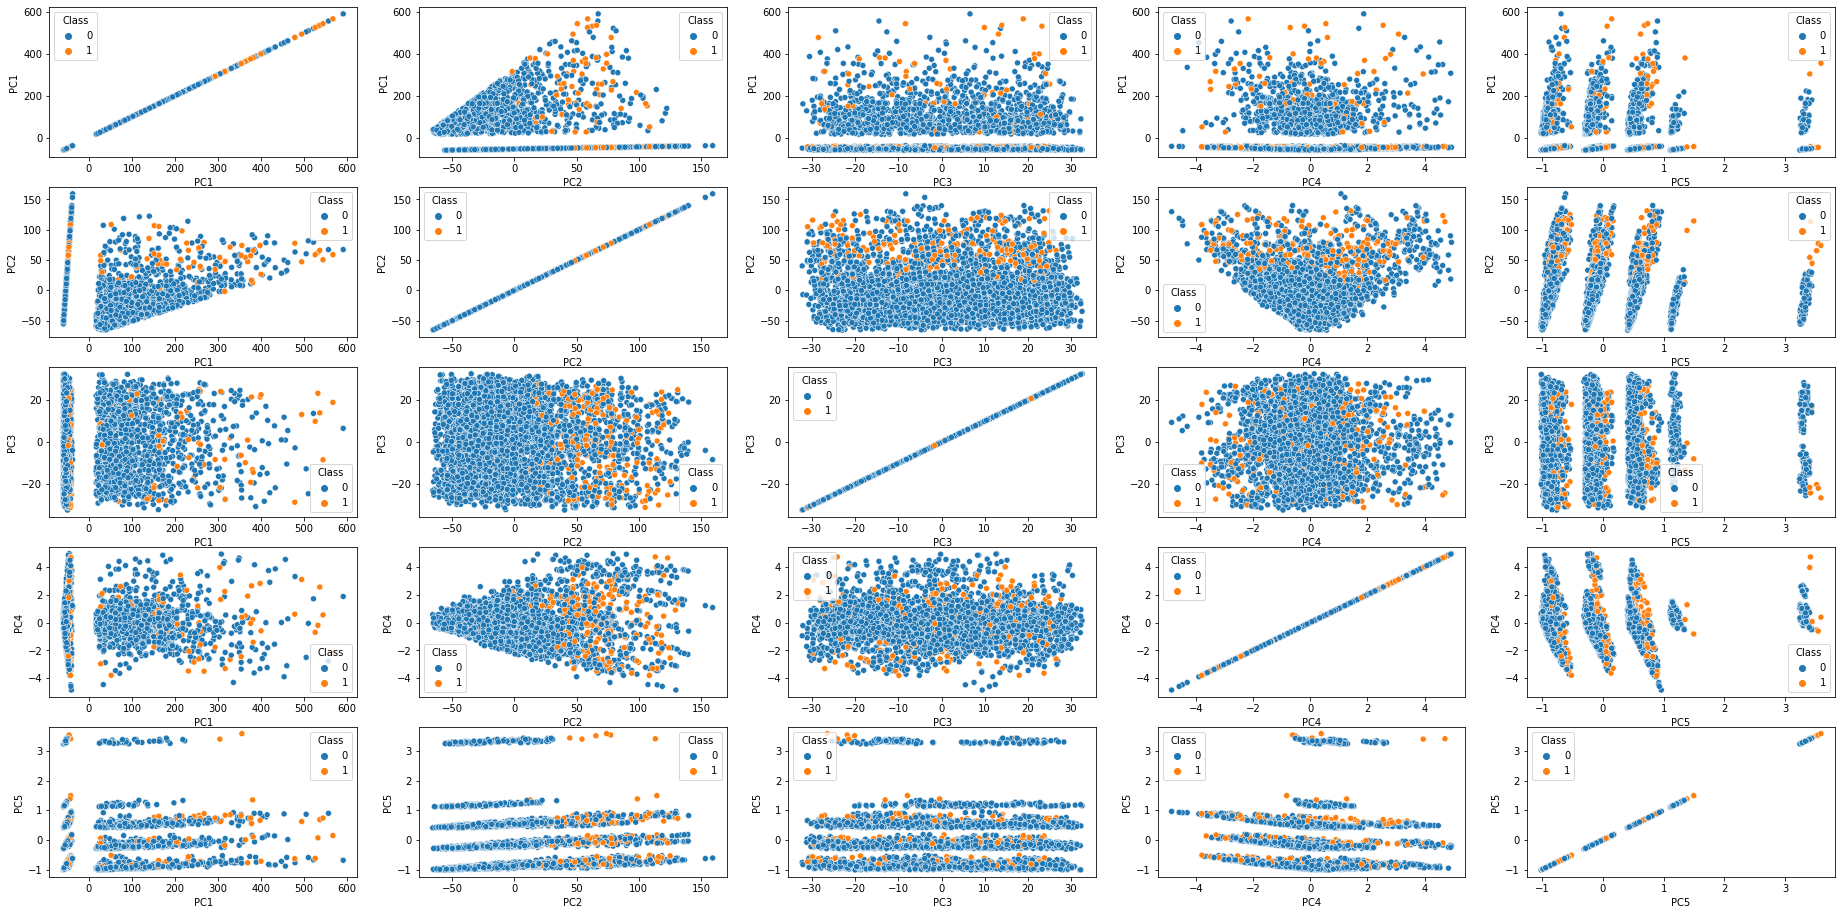

In [12]:
# create some scatterplots based on features and see if you can see some pattern in the data
fig ,ax = plt.subplots(5,5,figsize=(32,16))
for i in range(1,6):
    for j in range(1,6):
        sns.scatterplot(x='PC'+ str(j),y='PC'+str(i),data=data,hue='Class',ax=ax[i-1][j-1])

# sns.scatterplot(x='PC3',y='PC4',data=data,hue='Class',ax=ax1)
# sns.scatterplot(x='PC2',y='PC5',data=data,hue='Class',ax=ax2)

### Evaluation metric selection

In [13]:
# baseline accuracy of the model

round(data['Class'].value_counts(normalize=True) * 100, 2)

0    96.17
1     3.83
Name: Class, dtype: float64

For this dataset let's consider fraudulent transactions (which are denoted as 1 in the dataset) is `positive` class and the non fraudulent transactions (which are denoted as 0 in the dataset) is `negative` class.

- TP - transactions which are actually fraudulent and the model also able correctly identify them as fraudulent transactions
- FP - transactions which are actually non fraudulent transactions but the model is predicting them as fraudulent transactions
- TN - transactions which are actually non fraudulent transactions and model is also predicting them as non fraudulent transactions
- FN - transactions which are actually fraudulent but the model is predicting them as non fraudulent transactions

Out of the misclassifications - FN (False negative) and FP (False positive) which one is costlier for this business problem?

$$recall = \frac{TP}{TP + FN}$$

$$precision = \frac{TP }{TP+ FP}$$

###  Baseline model

In [14]:
# drop the ID variable as it is unique for all the transactions and does not have any meaningful information about the data
data = data.drop(['ID'],axis=1)

In [15]:
# extract features and target from the original dataset
features = data.drop(['Class'],axis=1)
target = data['Class']

In [16]:
# split the dataset into trainig and test set to train and evaluate the model respectively
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state =42)

In [17]:
# create a random forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [18]:
# predict for the test dataset
y_predict = rf.predict(x_test)

<AxesSubplot:>

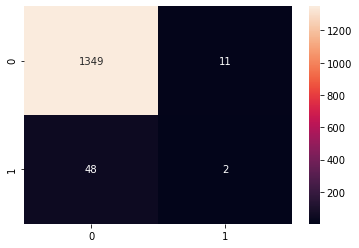

In [19]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='0.0f')

In [20]:
# print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1360
           1       0.15      0.04      0.06        50

    accuracy                           0.96      1410
   macro avg       0.56      0.52      0.52      1410
weighted avg       0.94      0.96      0.95      1410



###  Resampling techniques for imbalanced data

The imbalanced datasets are generally biased towards the majority class of the target variable. In this case the majority class is non fraudulent transactions and the minority class is fraudulent transactions. Hence if we don't balance these two classes the machine learning algorithms will be biased towards the majority class. Therefore it becomes important to balance the classes present in target variables. There are two ways in which we can balance these two categories - 

- **Undersampling**: In undersampling we randomly select as many observations of majority class as we have for minority class to make both of these classes balanced
- **Oversampling**: In oversampling, we create multiple copies of minority class to have same number of observations as we have for majority class. Here also we can oversampling in two ways - 
    - **Minotiy Oversampling**: here we create duplicates of same data from minority class
    - **SMOTE (Synthetic Minority Oversampling Technique)**: here we create observations for the minority class, based on those that already exist. It randomly picks a point from the minority class and computes the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

#### Synthetic Minority Oversampling Technique (SMOTE)

In [21]:
# import imblearn library and resample the original data using SMOTE technique
import imblearn as imb
smote = imb.over_sampling.SMOTE(random_state=42)
X_smote,Y_smote = smote.fit_resample(x_train,y_train)

In [22]:
# train a random forest model on SMOTE data
rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X_smote,Y_smote)


RandomForestClassifier(random_state=42)

<AxesSubplot:>

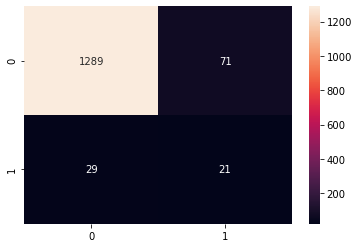

In [23]:
# predict the classes on test data using model built on SMOTE data and plot the confusion matrix
y_pred = rf1.predict(x_test)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='0.0f')

In [24]:
# print the classification report
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1360
           1       0.23      0.42      0.30        50

    accuracy                           0.93      1410
   macro avg       0.60      0.68      0.63      1410
weighted avg       0.95      0.93      0.94      1410



### Computing ROC AUC Curve

By defualt, every machine learning algorithm uses a probability threshold of 0.5 to classify between positive and negative classes. If we can tune this probability threshold to some other values which increases the true positive rate then we will be able to increase the recall for fraudulent transactions.

To do that we need to compute the AUC score. The AUC score signifies that the probability value of a random observation from the positive class (i.e. fraudulent transactions) is larger than the probability value of another random observation from the negative class (i.e. non fraudulent transactions). AUC value of 1 means all the predicted positive (fraudulent) transactions have higher probabilites of being fraudulent than the non fraudulent transactions, which is an ideal case. 

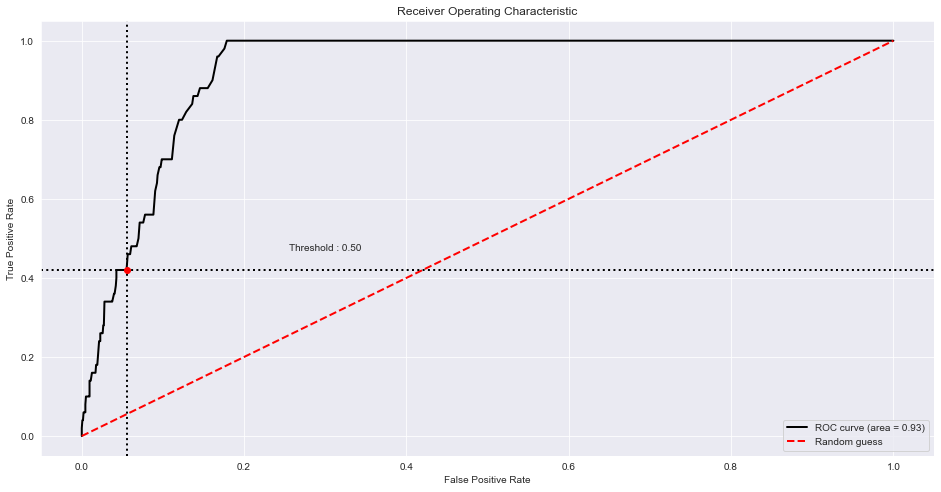

In [27]:
# let's compute the AUC curve for the model we developed on SMOTE data
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test,rf1.predict_proba(x_test)[:,1],labels=[0,1])
plt.figure(figsize=(16,8))
bc.plot_roc_curve()
plt.show()

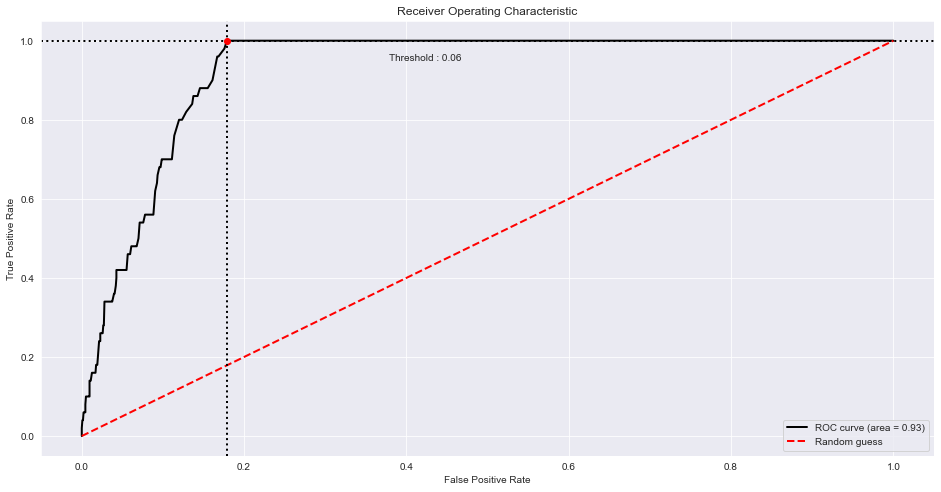

In [28]:
# let's use another probability threshold so that we can get to the elbow position in the above curve
bc = BinaryClassification(y_test,rf1.predict_proba(x_test)[:,1],threshold= 0.06,labels=[0,1])
plt.figure(figsize=(16,8))
bc.plot_roc_curve()
plt.show()

###  Adjusting probability threshold

In [29]:
# compute the probabilites of test observations using rf_smote model
y_pred_prob = rf1.predict_proba(x_test)[:,1]


In [30]:
# compare these probabilities against the probability threshold of 6% rather than the default threshold of 50%
y_pred_labels = (y_pred_prob >=0.06)


<AxesSubplot:>

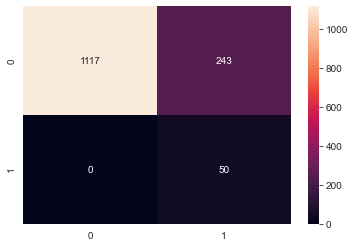

In [31]:
# plot the confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred_labels),annot=True,fmt='0.0f')

In [32]:
# print the classification report
print(classification_report(y_test,y_pred_labels))


              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1360
           1       0.17      1.00      0.29        50

    accuracy                           0.83      1410
   macro avg       0.59      0.91      0.60      1410
weighted avg       0.97      0.83      0.88      1410

